In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import scipy.spatial
import functools
import qgrid 
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
%matplotlib inline

In [2]:
def linear_kernel(W , X) :
    '''
    线性核函数计算. K(W_i , X_j) = W_i^T * X_j
    Args:
        W - 中心点/参考点特征 , 二维numpy矩阵 (num_prototypes , num_features)
        X - 相对点特征 , 二维numpy矩阵(num_instances , num_features)
    Returns:
        K - 核矩阵 , 二维numpy矩阵(num_prototypes , num_instances)
    '''
    K = np.matmul(W , X.T)
    return K

def RBF_kernel(W , X , sigma) :
    '''
    RBF核函数计算. K(W_i , X_j) = exp(-|W_i-X_j|^2/2*sigma).利用了scipy.spatial.distance.cdist函数,可以高效计算各种距离.
    Args:
        W - 中心点/参考点特征 , 二维numpy矩阵 (num_prototypes , num_features)
        X - 相对点特征 , 二维numpy矩阵(num_instances , num_features)
    Returns:
        K - 核矩阵 , 二维numpy矩阵(num_prototypes , num_instances)
    '''
    dis = scipy.spatial.distance.cdist(W , X , "sqeuclidean")
    return np.exp(- (dis) / (2 * sigma**2))

def polynomial_kernel(W , X , offset , degree) :
    '''
    多项式核函数计算. K(W_i , X_j) = (offset + W_i^T * X_j) ^ degree
    Args:
        W - 中心点/参考点特征 , 二维numpy矩阵 (num_prototypes , num_features)
        X - 相对点特征 , 二维numpy矩阵(num_instances , num_features)
    Returns:
        K - 核矩阵 , 二维numpy矩阵(num_prototypes , num_instances)
    '''
    return (offset + np.matmul(W , X.T)) ** degree

In [3]:
def plot_func(kernel , kernel_name , prototypes = None) :
    '''
    
    Args:
        kernel - 核函数类型 , 函数
        kernel_name - 用于作图label的核函数名称 , 字符串
        prototypes - 中心点 , 二维numpy数组(num_prototypes , num_features)
    Returns:
        图像
    '''
    plot_step = 0.01
    points_x = np.arange(-6.0 , 6 , plot_step).reshape(-1 , 1)
    prototypes = np.array([4 , -1 , 0 , 2]).reshape(-1 , 1)
    y = kernel(prototypes , points_x)
    
    for i in range(len(prototypes)) :
        label = kernel_name + ' kernel ' + str(prototypes[i])
        plt.plot(points_x , y[i] , label = label)
    plt.legend(loc = 'best')
    plt.show()

In [4]:
class Kernel_Machine(object) :
    '''
    核机器类
    '''
    def __init__(self , kernel , prototypes , weights) :
        '''
        初始化方法.
        Args:
            kernel - 核函数类型 , 函数
            prototypes - 中心点 , 二维numpy数组(num_prototypes , num_features)
            weights - 权重系数 , 一维numpy数组(num_prototypes)
        '''
        self.kernel = kernel
        self.prototypes = prototypes
        self.weights = weights
    
    def predict(self , X) :
        '''
        核机器预测函数
        Args:
            X - 待预测样本特征 , 二维numpy数组(num_instances , num_features)
        Returns:
            y - 预测值 , 一维numpy数组(num_instances)
        '''
        K = self.kernel(self.prototypes , X)
        y = np.matmul(K.T , self.weights)
        return y

In [5]:
def Experiment1() :
    '''
    实验一:研究核函数图像与中心点以及参数的关系.
    '''
    rbf = functools.partial(RBF_kernel , sigma = 2)
    plot_func(rbf , "RBF")
    linear = functools.partial(linear_kernel)
    plot_func(linear , 'linear')
    poly = functools.partial(polynomial_kernel , offset = 1 , degree = 3)
    plot_func(poly , 'poly')
    plot_step = 0.01
    points_x = np.arange(-6.0 , 6 , plot_step).reshape(-1 , 1)
    rbf_machine = Kernel_Machine(functools.partial(RBF_kernel , sigma = 1) , 
                                 np.array([-1 , 0 , 1]).reshape(-1 , 1) , [1 , -1 , 1])
    y = rbf_machine.predict(points_x)
    label = "Rbf"
    plt.plot(points_x , y , label = label)
    plt.legend()
    plt.show()

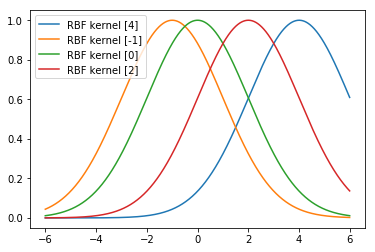

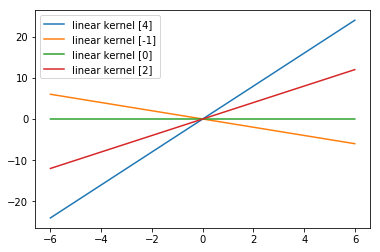

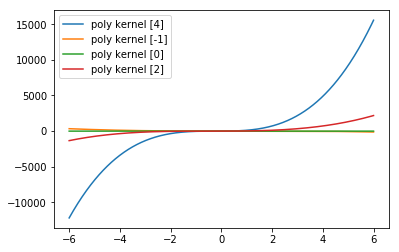

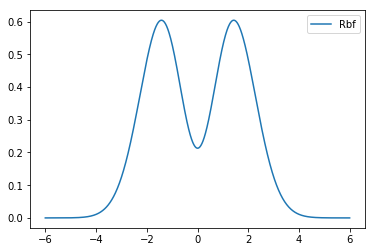

In [6]:
Experiment1()

In [7]:
def train_kernel_ridge_regression(X , y , kernel , lambda_reg) :
    '''
    训练核化的ridge regression模型.注意有闭式解且效率很高,因为是对正定矩阵求逆.
    Args:
        X - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)  p.s. num_instances = num_prototypes
        y - 训练样本输出值 , 一维numpy数组(num_instances)
        kernel - 核函数类型 , 函数
        lambda_reg - L2正则系数 , 标量
    Returns:
        f - 核机器 , 核机器类
    '''
    K = kernel(X , X)
    dim_K = K.shape[0]
    alpha = np.matmul(np.linalg.inv(lambda_reg * np.identity(dim_K) + K) , y)
    return Kernel_Machine(kernel , X , alpha)

In [8]:
def load_ridge_data() :
    '''
    读取kernelized ridge regression所用的训练数据和测试数据.
    Args:
        None
    Returns:
        X_train - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)
        y_train - 训练样本输出 , 一维numpy数组(num_instances)
        X_test - 测试样本输入特征 , 二维numpy数组(num_instances , num_features)
        y_test - 测试样本输出 , 一维numpy数组(num_instances)
    '''
    data_train= np.loadtxt('data/krr-train.txt')
    data_test = np.loadtxt('data/krr-test.txt')
    X_train = data_train[ : , 0].reshape(-1 , 1)
    y_train = data_train[ : , 1].reshape(-1 , 1)
    X_test = data_test[ : , 0].reshape(-1 , 1)
    y_test = data_test[ : , 0].reshape(-1 , 1)
    figsize = plt.figaspect(1)
    f, (ax) = plt.subplots(1, 1, figsize= [20 , 10]) 
    ax.scatter (X_train , y_train , marker='.', c='r')
    plt.show()
    return X_train , y_train , X_test , y_test

In [11]:
def Experiment2() :
    '''
    实验二.训练使用RBF核的kernelized ridge regression model. 研究lambda_reg和sigma对模型效果的影响.
    '''
    X_train , y_train , X_test , y_test = load_ridge_data()
    plot_step = 0.001
    points_x = np.arange(0 , 1 , plot_step).reshape(-1 , 1)
    plt.figure(figsize = (20,10))
    plt.plot(X_train , y_train , 'o')
    lambda_reg = 0.0001
    for sigma in [.01,.1,1]:
        k = functools.partial(RBF_kernel , sigma = sigma)
        f = train_kernel_ridge_regression(X_train , y_train , k , lambda_reg = lambda_reg)
        label = "Sigma=" + str(sigma) + ",lambda_reg=" + str(lambda_reg)
        points_y = f.predict(points_x)
        plt.plot(points_x , points_y , label=label)
    plt.legend(loc = 'best')
    plt.ylim(-1 , 1.5)
    plt.show()
    sigma = 0.02
    plt.figure(figsize = [20 , 10])
    plt.plot(X_train , y_train , 'o')
    for lambda_reg in [0.0001 , 0.01 , 0.1 , 2.0] :
        k = functools.partial(RBF_kernel , sigma = sigma)
        f = train_kernel_ridge_regression(X_train , y_train , k , lambda_reg = lambda_reg)
        label = "Sigma=" + str(sigma) + ",lambda_reg=" + str(lambda_reg)
        points_y = f.predict(points_x)
        plt.plot(points_x , points_y , label = label)
    
    plt.legend(loc = 'best')
    plt.ylim(-1 , 1.5)
    plt.show()

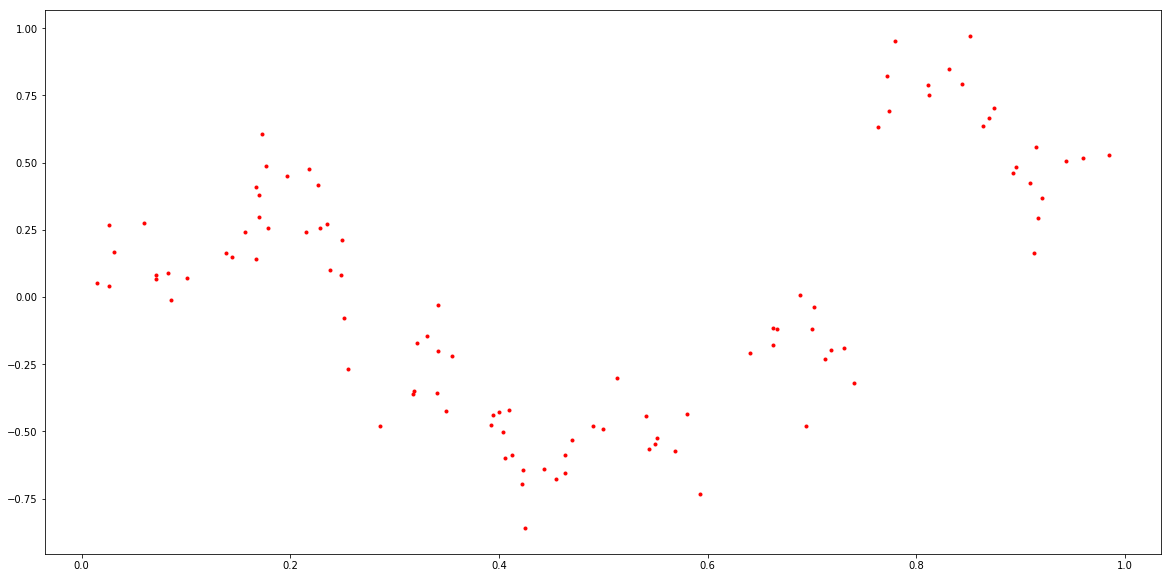

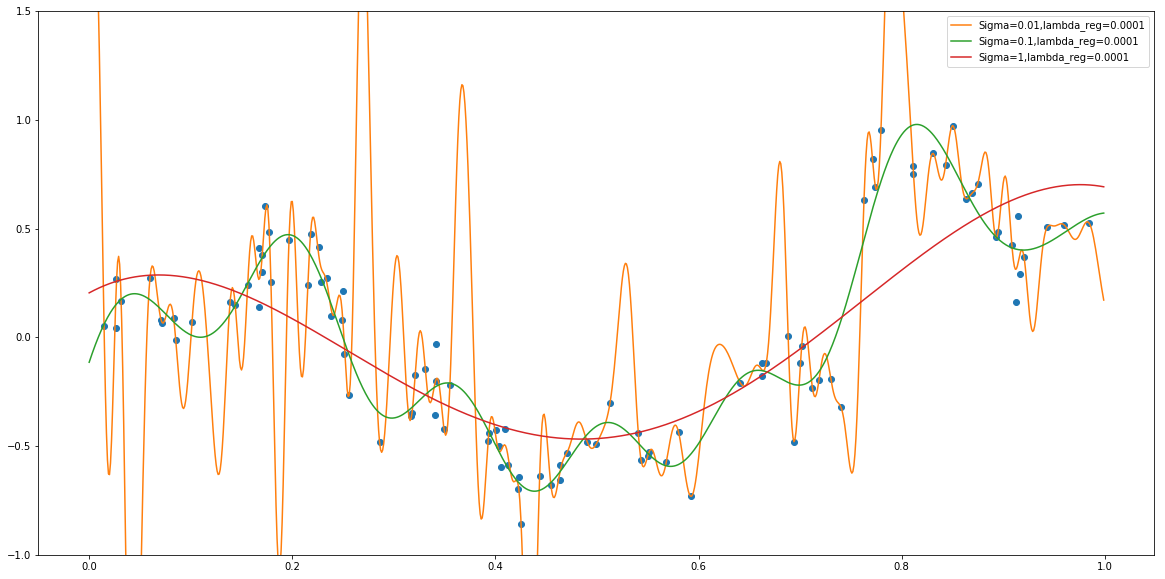

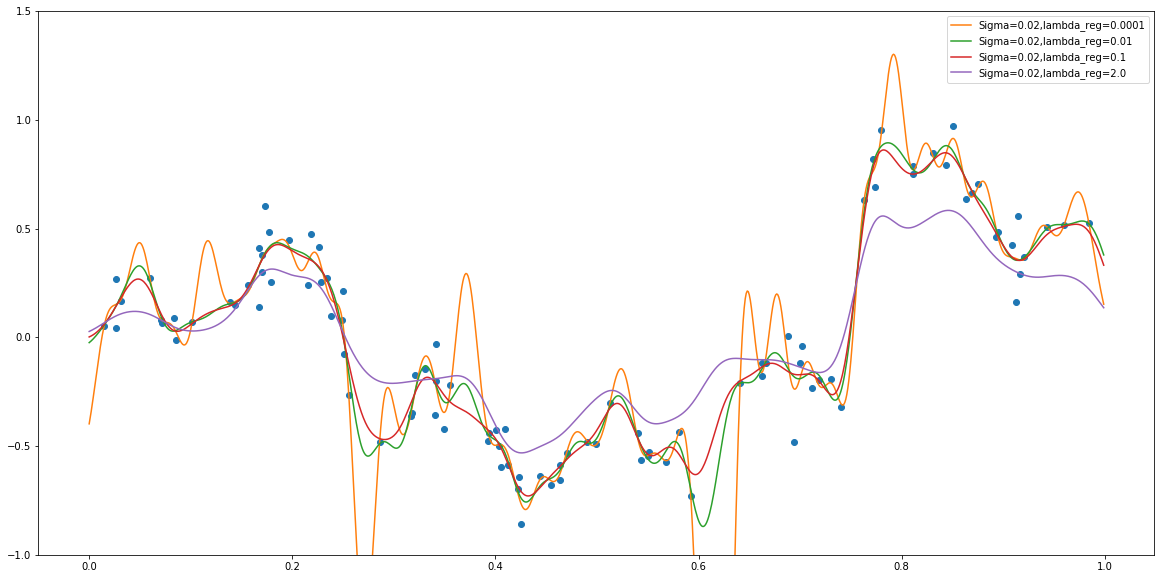

In [12]:
Experiment2()

In [13]:
class Kernel_Ridge_Regression(BaseEstimator , RegressorMixin) :
    '''
    kernelized ridge regression类,方便实现参数搜索.
    '''
    def __init__ (self , kernel = "RBF" , sigma = 1 , offset = 1 , degree = 2 , lambda_reg = 1) :
        '''
        类成员变量初始化.
        Args:
            kernel - 核函数类型 , 函数
            sigma - RBF核函数参数 , 影响半径 , 标量
            offset - 多项式核函数参数 , 截距 , 标量
            degree - 多项式核函数参数 , 次数 , 标量
            lambda_reg - L2正则系数 , 标量
        '''
        self.kernel = kernel
        self.sigma = sigma
        self.offset = offset
        self.degree = degree
        self.lambda_reg = lambda_reg
    
    def fit(self , X , y = None) :
        '''
        拟合函数.根据核函数类型,具体调用已经实现好的训练函数.
        Args:
            X - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)  p.s. num_instances = num_prototypes
            y - 训练样本输出值 , 一维numpy数组(num_instances)
        '''
        if (self.kernel == "linear") :
            self.k = linear_kernel
        elif (self.kernel == "polynomial") :
            self.k = functools.partial(polynomial_kernel , offset = self.offset , degree = self.degree)
        elif (self.kernel == "RBF") :
            self.k = functools.partial(RBF_kernel , sigma = self.sigma)
        else :
            raise ValueError('Unrecognized kernel type requested.')
        #一个好的书写习惯,防止命名冲突
        self.kernel_machine_ = train_kernel_ridge_regression(X , y , self.k , self.lambda_reg)
    
    def predict(self , X) :
        '''
        预测函数.
        X - 待预测样本输入特征 , 二维numpy数组(num_instances , num_features)
        '''
        try :
            getattr(self , "kernel_machine_")
        except AttributeError :
            raise RuntimeError("You must train model before predicting...")
        return self.kernel_machine_.predict(X)
    
    def score(self , X , y) :
        '''
        模型评分函数.这里默认使用的是均方差,GridSearch要求score越大越好,所以直接调用该评分函数的话要注意参数设置.
            X - 用于评分的样本输入特征 , 二维numpy数组(num_instances , num_features)
            y - 用于评分的样本输出 , 一维numpy数组(num_instances)
        '''
        return ((self.predict(X) - y)**2).mean()

In [14]:
def plot_line(X_train , y_train , X_test , y_test , kernel , kernel_name , lambda_reg = 1) :
    '''
    利用已训练好的核机器,绘制指定坐标区间内的拟合函数.
    Args:
        X_train - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)
        y_train - 训练样本输出 , 一维numpy数组(num_instances)
        X_test - 测试样本输入特征 , 二维numpy数组(num_instances , num_features)
        y_test - 测试样本输出 , 一维numpy数组(num_instances)
        kernel - 核函数类型 , 函数
        kernel_name - 核函数名称 , 字符串
        lambda_reg - L2正则系数 , 标量
    '''
    plot_step = 0.01
    points_x = np.arange(-0.5 , 1.5 , plot_step).reshape(-1 , 1)
    plt.figure(figsize = (20,10))
    plt.plot(X_train , y_train , 'o' , color = 'red')
    plt.plot(X_test , y_test , 'o' , color = 'green')
    f = train_kernel_ridge_regression(X_train , y_train , kernel , lambda_reg)
    points_y = f.predict(points_x)
    label = kernel_name + ' kernel'
    plt.plot(points_x , points_y , label = label)
    plt.legend(loc = 'best')
    plt.ylim(-1 , 1.5)
    plt.show()

In [15]:
def Experiment3() :
    '''
    划分训练集,验证集.通过GridSearchCV搜索最优的一组超参数.绘制三种不同核函数对应的最优超参数的拟合图像.
    '''
    X_train , y_train , X_test , y_test = load_ridge_data()
    test_fold = [-1] * len(X_train) + [0] * len(X_test)
    predefined_split = PredefinedSplit(test_fold = test_fold)
    param_grid = [{'kernel': ['RBF'],'sigma':[0.1,1,10], 'lambda_reg': np.exp2(-np.arange(-5,5,1))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4],'lambda_reg':[10, 0.1, 0.01] },
              {'kernel':['linear'],'lambda_reg': [10,1,0.01]}]
    kernel_ridge_regression_estimator = Kernel_Ridge_Regression()
    grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
    grid.fit(np.vstack((X_train,X_test)),np.vstack((y_train,y_test))) 
    pd.set_option('display.max_rows', 20)
    df = pd.DataFrame(grid.cv_results_)
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_degree", "param_kernel","param_lambda_reg" ,"param_offset","param_sigma",
            "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow.sort_values(by=["mean_test_score"])
    df_poly = df_toshow[df['param_kernel'] == "polynomial"]
    df_poly.sort_values(by = ['mean_test_score'])
    df_rbf = df_toshow[df['param_kernel'] == "RBF"]
    df_rbf.sort_values(by = ["mean_test_score"])
    df_linear = df_toshow[df['param_kernel'] == 'linear']
    df_linear.sort_values(by = ['mean_test_score'])
    offset = -1
    lambda_reg = 10
    degree = 2
    k = functools.partial(polynomial_kernel , offset = offset , degree = degree)
    plot_line(X_train , y_train , X_test , y_test , k , 'poly' , lambda_reg = lambda_reg)
    lambda_reg = 1
    sigma = 1
    k = functools.partial(RBF_kernel , sigma = sigma)
    plot_line(X_train , y_train , X_test , y_test , k , 'RBF' , lambda_reg = lambda_reg)
    lambda_reg = 0.01
    k = functools.partial(linear_kernel)
    plot_line(X_train , y_train , X_test , y_test , k , 'linear' , lambda_reg = lambda_reg)

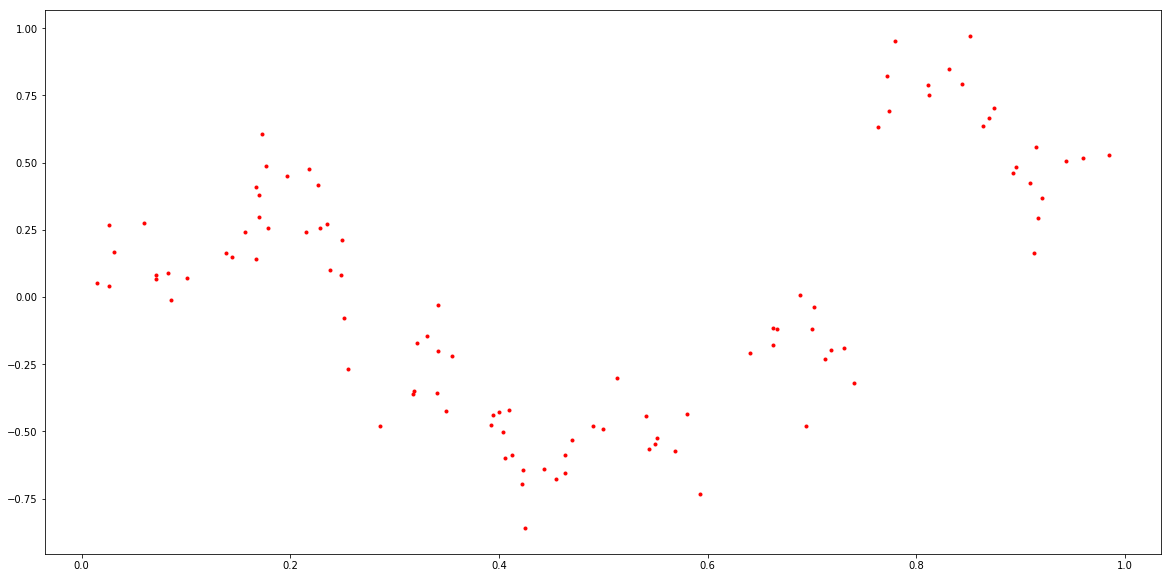

/Users/zhangjunrui/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zhangjunrui/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/zhangjunrui/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


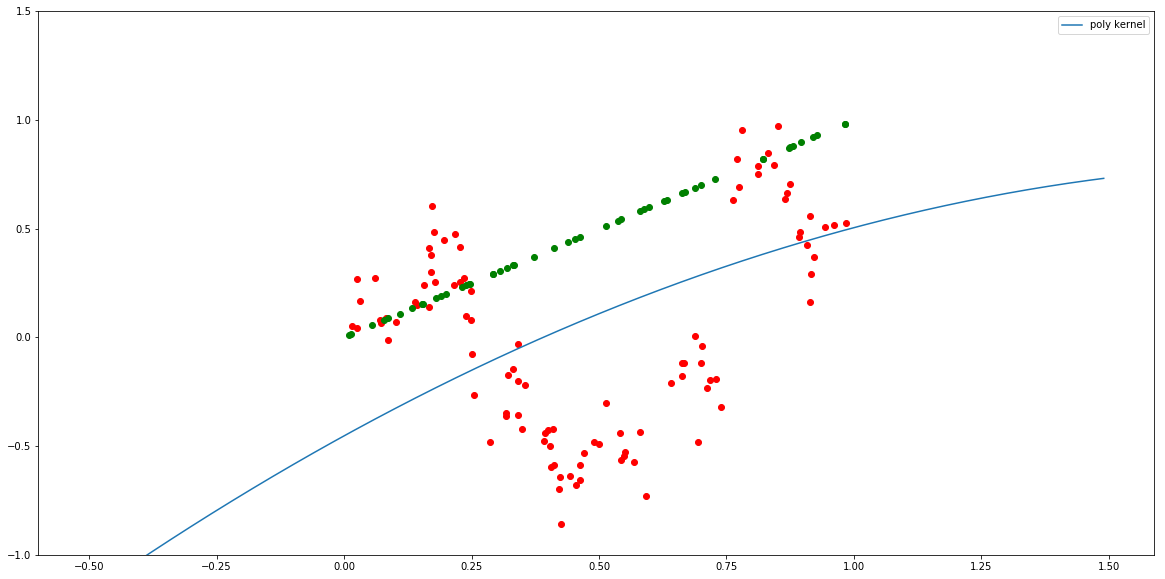

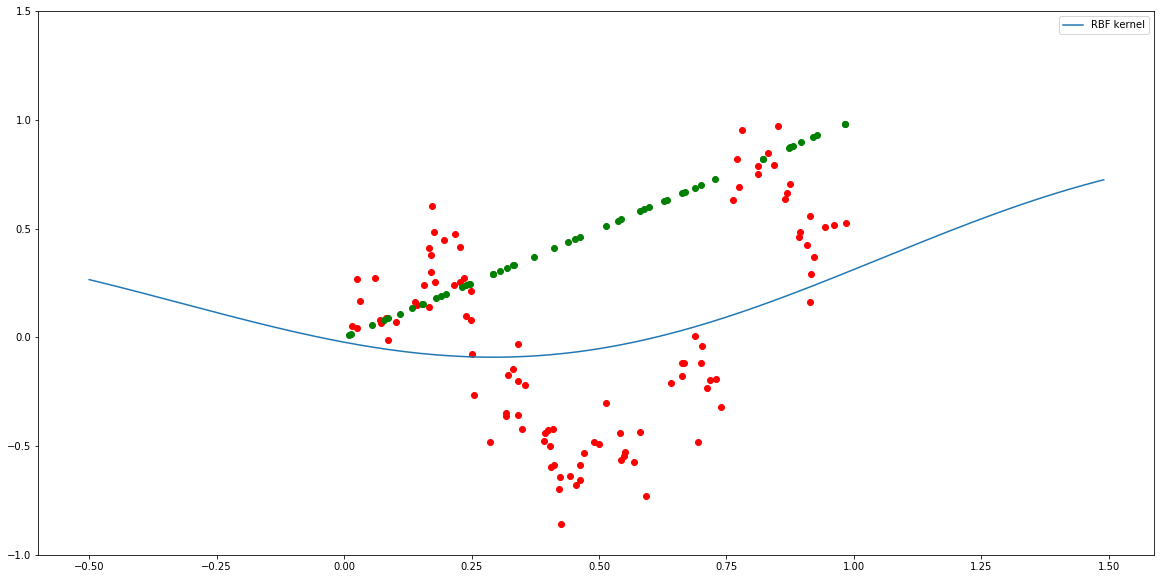

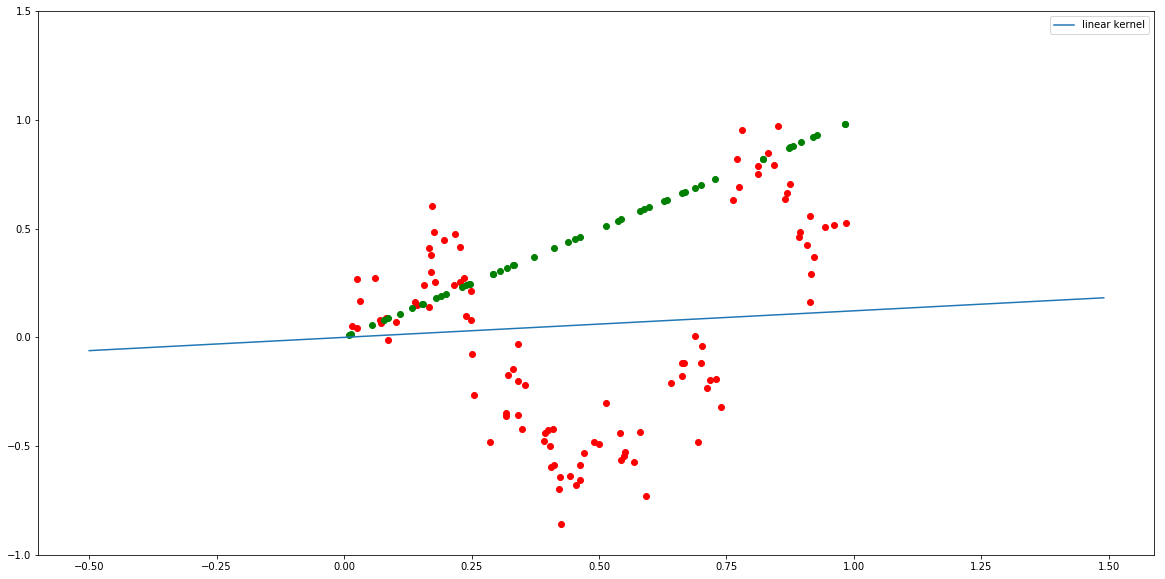

In [16]:
Experiment3()

In [18]:
def load_svm_data() :
    '''
    读取kernelized SVM 所用的训练数据和测试数据.
    Args:
        None
    Returns:
        X_train - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)
        y_train - 训练样本输出 , 一维numpy数组(num_instances)
        X_test - 测试样本输入特征 , 二维numpy数组(num_instances , num_features)
        y_test - 测试样本输出 , 一维numpy数组(num_instances)
    '''
    data_train = np.loadtxt('data/svm-train.txt')
    data_test = np.loadtxt('data/svm-test.txt')
    X_train = data_train[ : , 0 : 2]
    y_train = data_train[ : , 2].reshape(-1 , 1)
    X_test = data_test[ : , 0 : 2]
    y_test = data_test[ : , 2].reshape(-1 , 1)
    yplus = np.ma.masked_where(y_train[ : , 0] <= 0 , y_train[ : , 0])
    xplus = X_train[~np.array(yplus.mask)]
    yminus = np.ma.masked_where(y_train[ : , 0] > 0 , y_train[ : , 0])
    xminus = X_train[~np.array(yminus.mask)]

    f , (ax) = plt.subplots(1 , 1 , figsize = (10 , 10))
    ax.scatter(xplus[ : , 0] , xplus[ : , 1] , marker = '+' , c = 'r' , label = '+1')
    ax.scatter(xminus[ : , 0] , xminus[ : , 1] , marker = '$-$' , c = 'b' , label = '-1')
    ax.set_ylabel(r"$x_2$" , fontsize = 11)
    ax.set_xlabel(r"$x_1$" , fontsize = 11)
    for i in range(len(y_train)) :
        if (y_train[i][0] < 0) :
            y_train[i][0] = -1
        elif (y_train[i][0] > 0) :
            y_train[i][0] = 1
    return X_train , y_train , X_test , y_test

In [19]:
def train_soft_svm(X , y , kernel , lambda_reg , num_iter = 50) :
    '''
    利用peagsos算法训练kernelized SVM,返回对应核机器.
    Args:
        X - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)
        y - 训练样本label , 一维numpy数组(num_instances)
        kernel - 核函数类型 , 函数
        lambda_reg - L2正则系数 , 标量
        num_iter - 最大迭代轮数 , 标量
    Returns:
        kernel_machine - 核机器 , 核机器类
    '''
    K = kernel(X , X)
    dim_K = K.shape[0]
    alpha = np.zeros(dim_K)
    t = 0
    for epoch in range(num_iter) :
        for i in range(dim_K) :
            t += 1
            eta = 1 / (lambda_reg * t)
            pred = np.matmul(K[i]  , alpha)
            if (y[i][0] * pred < 1) :
                alpha = alpha - lambda_reg * eta * np.matmul(K , alpha)  + y[i][0] * eta * K[i]
            else :
                alpha = alpha - lambda_reg * eta * np.matmul(K , alpha) 
    return Kernel_Machine(kernel , X , alpha)
    

In [23]:
def plot_graph(X_train , y_train , X_test , y_test , ff , kernel_name) :
    '''
    利用已训练好的核机器,绘制指定区域内核函数的等高线.
    Args:
        X_train - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)
        y_train - 训练样本输出 , 一维numpy数组(num_instances)
        X_test - 测试样本输入特征 , 二维numpy数组(num_instances , num_features)
        y_test - 测试样本输出 , 一维numpy数组(num_instances)
        ff - 核函数类型 , 函数
        kernel_name - 核函数名称 , 字符串
    '''
    x1_min = min(X_test[:,0])
    x1_max = max(X_test[:,0])
    x2_min = min(X_test[:,1])
    x2_max = max(X_test[:,1])
    h=0.1
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))
    Z = ff.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    y_bar = ff.predict (X_test) 
    yplus = np.ma.masked_where(y_bar<=0, y_bar)
    xplus = X_test[~np.array(yplus.mask)]
    yminus = np.ma.masked_where(y_bar>0, y_bar)
    xminus = X_test[~np.array(yminus.mask)]

    figsize = plt.figaspect(1)
    f, (ax) = plt.subplots(1, 1, figsize=[20 , 20]) 
    decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
    minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
    ax.set_ylabel(r"$x_2$", fontsize=11)
    ax.set_xlabel(r"$x_1$", fontsize=11)
    ax.set_title('SVM with ' + kernel_name , fontsize=9)  
    ax.axis('tight')
    ax.legend(handles=[pluses, minuses], fontsize=9)
    plt.show()

In [48]:
def Experiment4() :
    '''
    kernelized SVM的可视化. 线性核无法处理类Xor问题.修改的广义多项式核以及RBF核可以很好地处理复杂问题.
    '''
    X_train , y_train , X_test , y_test = load_svm_data()
    sigma = 1
    lambda_reg = 0.1
    k = functools.partial(RBF_kernel , sigma = sigma)
    ff = train_soft_svm(X_train , y_train , k , lambda_reg)
    plot_graph(X_train , y_train , X_test , y_test , ff , 'RBF')
    lambda_reg = 1
    k = functools.partial(linear_kernel)
    ff = train_soft_svm(X_train / (1e6) , y_train , k , lambda_reg)
    plot_graph(X_train , y_train , X_test , y_test , ff , 'linear')
    lambda_reg = 1
    offset = 0
    degree = 2
    k = functools.partial(polynomial_kernel , offset = offset , degree = degree)
    ff = train_soft_svm(X_train / (1e2) , y_train , k , lambda_reg)
    plot_graph(X_train , y_train , X_test , y_test  , ff , 'polynomial')
    

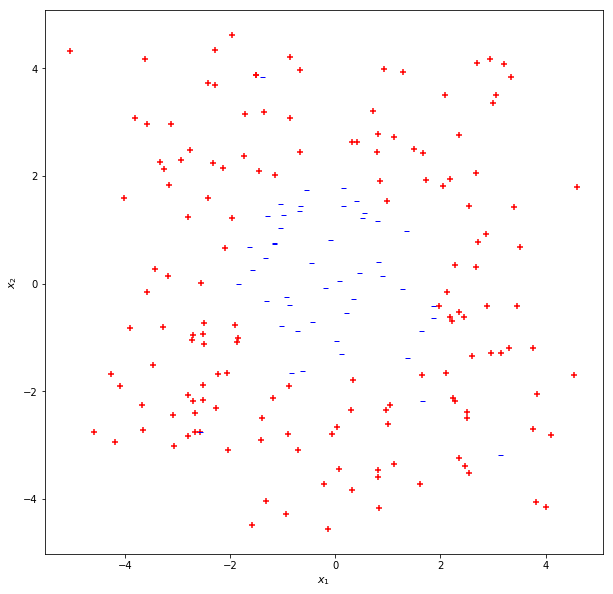

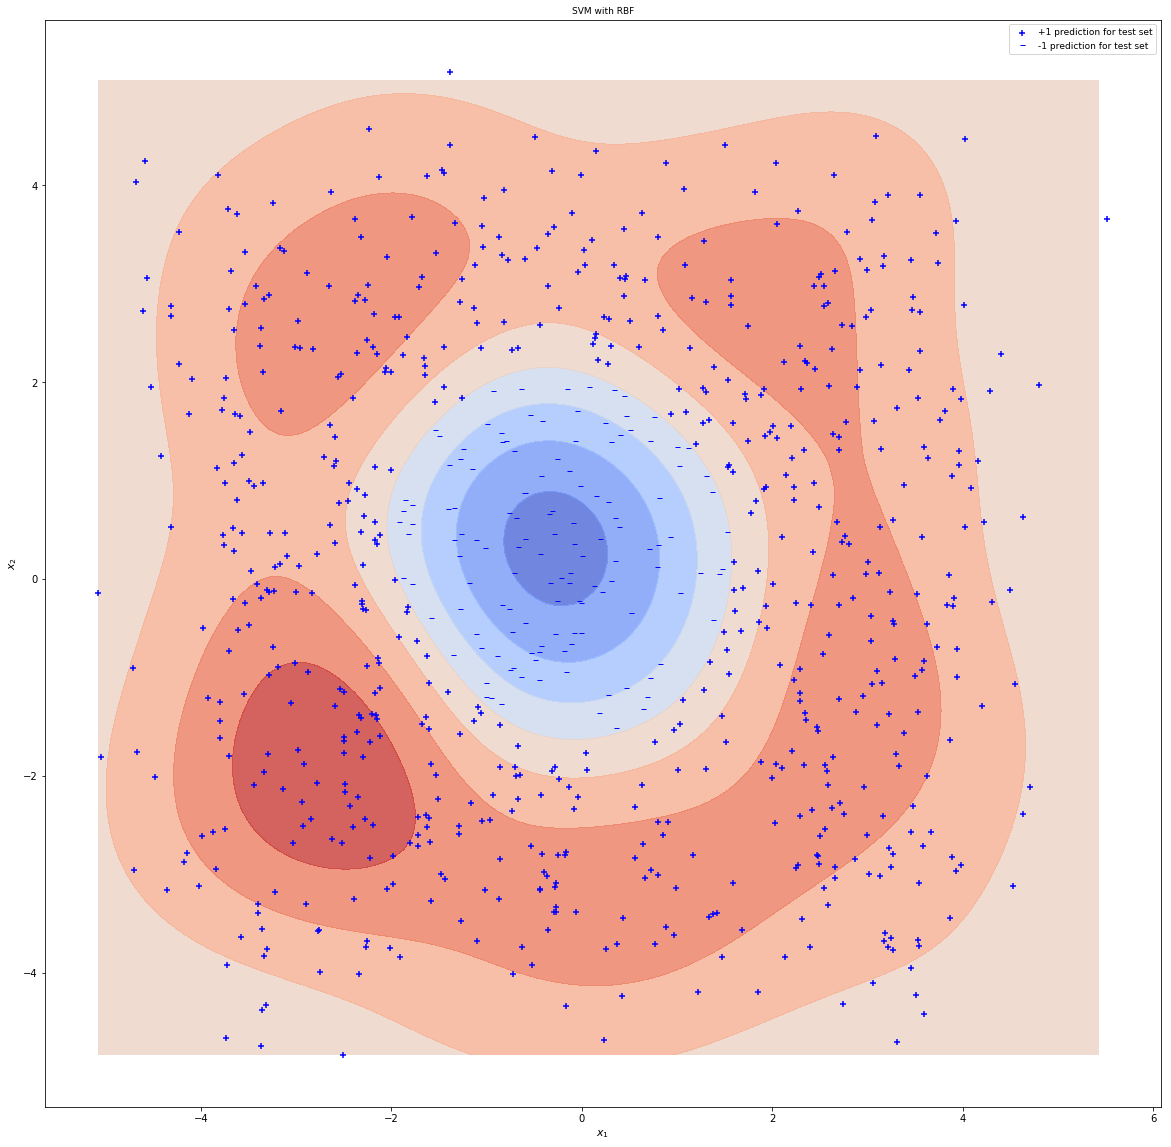

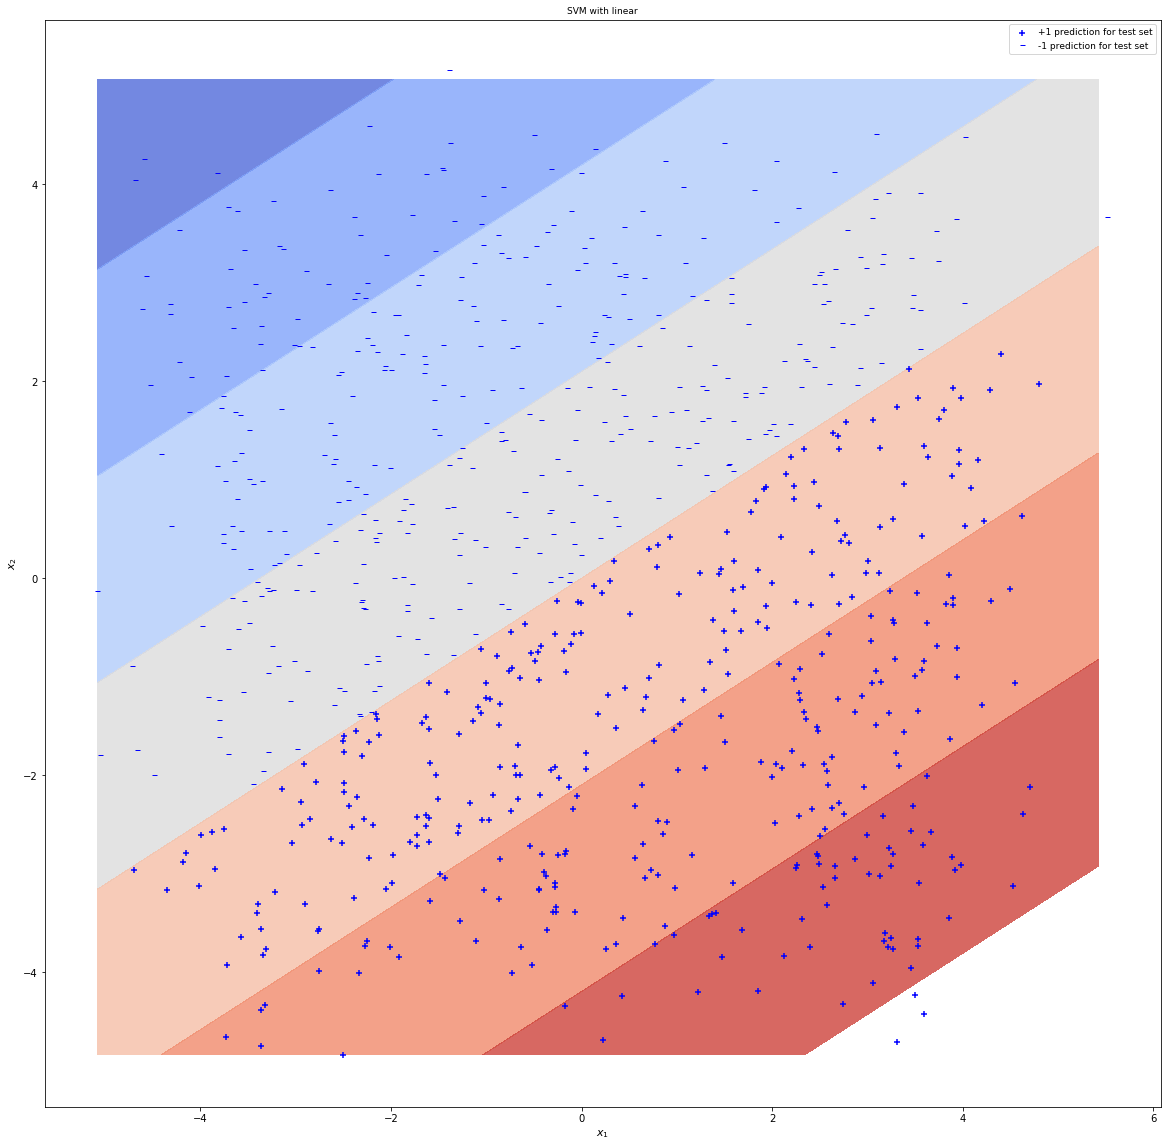

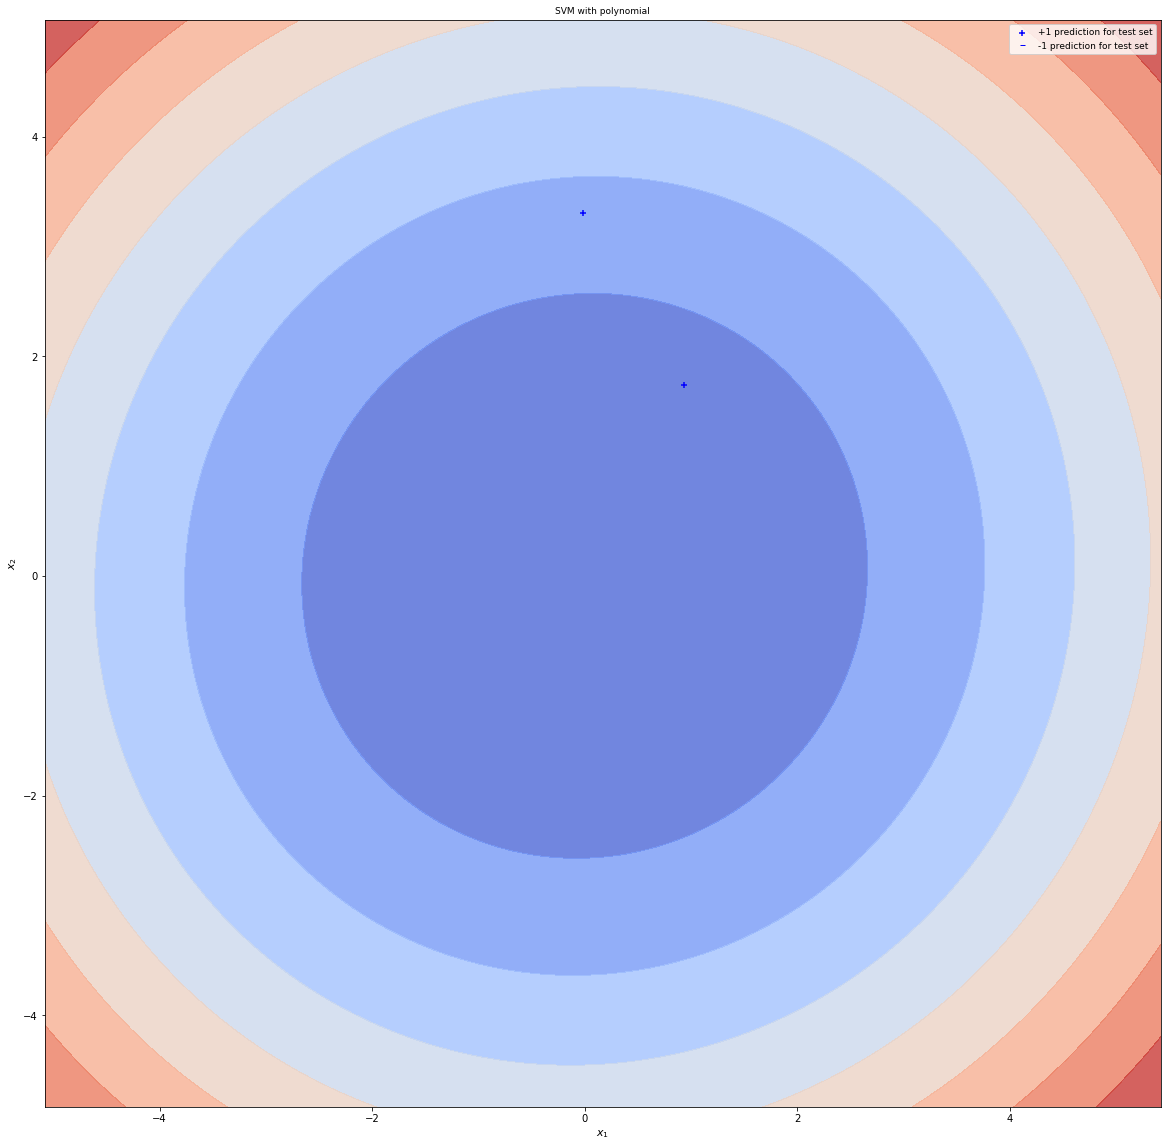

In [49]:
Experiment4()